#### What this notebook is:
This notebook is me doing tight iteration loops. I have my first set of reliable call measurements from an hour or two of manually selected calls - and now I want to see what kind of analysis can be done. 

Butt... before any of the actual analysis steps - the data needs to be cleaned and formatted. This notebook served as a testbed for finalising functions in the analysis workflow. 

#### What was actually achieved in this notebook:
* Establishment of data formatting and cleaning code to:
    1. Clean measurements from ```itsfm``` and eliminate poorly analysed datapoints
    2. Figure out the number of bats for each measurement ID in the measurements file output. 
* The final module coming from this is in the ```format_and_clean``` folder in this directory itself.


2020-05-21 16:59 

-- Thejasvi Beleyur

In [1]:
import glob
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 

dB = lambda X: 20*np.log10(abs(X))

In [2]:
def num_parts_in_call(call_rows):
    return call_rows.shape[0]

def num_parts_in_calldataset(df):
    '''
    Parameters
    ----------
    audio_file : pd.DataFrame
    
    Returns 
    -------
    num_parts_per_call : pd.DataFrame
            Naudio_files x 1 with the number of call parts per 
            unique audio file analysed
    '''
    each_call = df.groupby('audio_file')
    
    parts_per_call = []
    call_id = []
    for audio_file, each in each_call:
        parts_per_call.append(num_parts_in_call(each))
        call_id.append(audio_file)
        
    
    return pd.DataFrame(data={'audio_file':call_id,
                              'num_parts': parts_per_call},
                            index=range(len(each_call)))

def remove_badquality_points(results_folder, raw_msmts):
    '''
    Removes the rows which match the annotation audio in the 
    donot_analyse file from the raw_msmts pd.DataFrame. 
    
    Parameters
    ----------
    results_folder : str/path 
        path to the  the results folder with a donot_analyse.txt file in it
    raw_msmts : pd.DataFrame
        The DataFrame must have at least one column named 'audio_file'
    
    Returns
    -------
    cleaned_msmts: pd.DataFrame
        Version of raw_msmts without the audio files mentioned in the donot_analyse.txt
        If there are no files to be excluded the `donot_analyse.txt` file must 
        just have `None` in it. 
        Otherwise, each file to be excluded must be entered in a separate row. 
        The `donot_analyse.txt` file should not have a header. 
    '''
   
    filepath = os.path.join(results_folder, 'donot_analyse.txt')
    try:
        to_remove = pd.read_csv(filepath, header=None)
    except:
        raise ValueError(f'tried to read {filepath} -- is it there or formatted properly?')

    if np.logical_and(to_remove.shape==(1,1), to_remove[0][0]=='None'):
        cleaned_msmts = raw_msmts.copy()
    else:
        all_audio_files = raw_msmts
        rows_to_remove = []
        for _, each in to_remove.iterrows():
            rows = np.argwhere(raw_msmts['audio_file'].isin([each[0]]).tolist()).flatten()
            rows_to_remove.append(rows)
        all_rows_to_remove = np.concatenate(rows_to_remove)
        cleaned_msmts = raw_msmts.drop(all_rows_to_remove).reset_index(drop=True)
    return cleaned_msmts

def remove_these_audiofiles(audiofile, df):
    '''
    '''
    rows_to_remove = []
    for each in audiofile:
        rows = np.argwhere(df['audio_file'].isin([each]).tolist()).flatten()
        rows_to_remove.append(rows)
    all_to_remove = np.concatenate(rows_to_remove)
    return df.drop(all_to_remove).reset_index(drop=True)

def get_numbats_from_annotation_id(audio_file_ids, video_annotation_folder):
    '''
    Searches for all matching rows with the audio file id across all video annotation files
    and gets the number of bats observed in that annotation. 
    
    Parameters
    ----------
    audio_file_id : str
    video_annotation_folder : str/path
    
    Returns
    -------
    num_bats : int>0
        The number of bats in video over the annotation.
    '''

    # find and load all annotations from files
    all_annotations = read_all_annotation_files(video_annotation_folder)
  
    # search for each audio_file_id in DF
    num_bats = []
    for each in audio_file_ids:
        row_num = search_for_matching_id(each, all_annotations)
        num_flying_bats = get_num_flying_bats(row_num, all_annotations)
        num_bats.append(num_flying_bats)
    return num_bats

pandas_read_function = {'*.csv': pd.read_csv,
                       '*.xls': pd.read_excel}
        
def read_all_annotation_files(annotation_folder, file_format='*.csv'):
    '''
    Detects and loads all files of a matching format in the annotation folder into 
    one gian pd.DataFrame
    
    Parameters
    ----------
    annotation_folder : str/path
    file_format : list
        With the formats of the files. The format must be preceded with a *. 
        Defaults to '*.csv'
    
    Returns 
    -------
    all_annotations : pd.DataFrame
        All annotations loaded from detected annotation files in one dataframe.
    '''
    # load all matching format files
    all_matching_files = []
    candidate_path = os.path.join(annotation_folder, file_format)
    this_format_match =  glob.glob(candidate_path)
    all_matching_files += this_format_match
    
    # read all files
    all_annotation_container = []
    for each in all_matching_files:
        try:
            df = pandas_read_function[file_format](each)
        except UnicodeDecodeError:
            df = pandas_read_function[file_format](each, engine = 'python')
        
        all_annotation_container.append(df)
    
    all_annotations = pd.concat(all_annotation_container)
    return all_annotations
    
    
def search_for_matching_id(unique_id, annotations):
    '''
    Searches through a big dataframe with all video annotations. 
    Throws an error either if NO matches are found, or if more than one match is found. 

    Parameters
    ----------
    unique_id : str
    annotations = pd.DataFrame

    Returns 
    -------
    Int64Index 
        The row index where the matching ID is found. 

    '''
    match_found = annotations['annotation_id'].isin([unique_id])
    if sum(match_found) == 0:
        raise ValueError(f'{unique_id} not found among the given annotations')
    elif sum(match_found) >1:
        raise ValueError(f' Multiple matches found ({sum(match_found)}) for {unique_id} among the given annotations')
    return match_found.index[match_found]
    
def get_num_flying_bats(row_number, annotations):
    '''
    '''
    that_row = annotations.iloc[row_number,:]
    return int(that_row['no. of flying bats'])

remove_segment_matching_annotaudio_ = lambda X: X[28:]

In [3]:
video_annot_folder = '../../whole_data_analysis/annotations/corrected_HBC_video_annotations_Aditya/'
get_numbats_from_annotation_id(['Aditya_2018-08-17_01_3'], video_annot_folder)


[2]

In [4]:
%matplotlib notebook

In [5]:
results_folder = '2018-08-17_0100-0200/'
msmt_file = os.path.join(results_folder,'measurements_2018-08-17_0100-0200_batchfile.csv')
msmts = pd.read_csv(msmt_file)
# remove calls that couldn't be tracked properly written in the donot_analyse file:
good_quality = remove_badquality_points(results_folder, msmts)

### How many parts do calls have (2,3,4?):

In [6]:
call_parts = num_parts_in_calldataset(good_quality)
# remove all those with more than 3 parts!
ge_3 = call_parts['num_parts'] > 3

cleaned_call_parts = call_parts[~ge_3].reset_index(drop=True)
print(call_parts[ge_3])
toomany_callparts = call_parts[ge_3]['audio_file']
print(toomany_callparts)

                                           audio_file  num_parts
0   segment_matching_annotaudio_Aditya_2018-08-17_...          6
3   segment_matching_annotaudio_Aditya_2018-08-17_...          4
6   segment_matching_annotaudio_Aditya_2018-08-17_...          5
24  segment_matching_annotaudio_Aditya_2018-08-17_...          4
0     segment_matching_annotaudio_Aditya_2018-08-17_...
3     segment_matching_annotaudio_Aditya_2018-08-17_...
6     segment_matching_annotaudio_Aditya_2018-08-17_...
24    segment_matching_annotaudio_Aditya_2018-08-17_...
Name: audio_file, dtype: object


In [7]:
cleaned = remove_these_audiofiles(toomany_callparts, good_quality)
cleaned['video_annot_id'] = cleaned['audio_file'].apply(remove_segment_matching_annotaudio_)
cleaned['num_bats'] = get_numbats_from_annotation_id(cleaned['video_annot_id'], video_annot_folder)

<IPython.core.display.Javascript object>


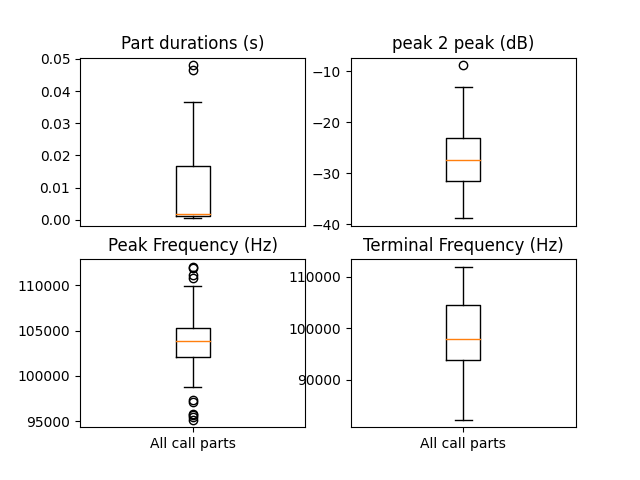

([<matplotlib.axis.XTick at 0x7f0d758a8a58>], [Text(0, 0, 'All call parts')])

In [8]:
plt.figure()
plt.subplot(221); plt.boxplot(cleaned['duration']);plt.title('Part durations (s)');plt.xticks([])
plt.subplot(222); plt.boxplot(dB(cleaned['peak_amplitude']));plt.title('peak 2 peak (dB)');plt.xticks([])
plt.subplot(223); plt.boxplot(cleaned['peak_frequency']);plt.title('Peak Frequency (Hz)');plt.xticks([])
plt.xticks([1],['All call parts'])
plt.subplot(224); plt.boxplot(cleaned['terminal_frequency']);plt.title('Terminal Frequency (Hz)');
plt.xticks([1],['All call parts'])

### How do the FM and CF parameters compare in general?

<IPython.core.display.Javascript object>


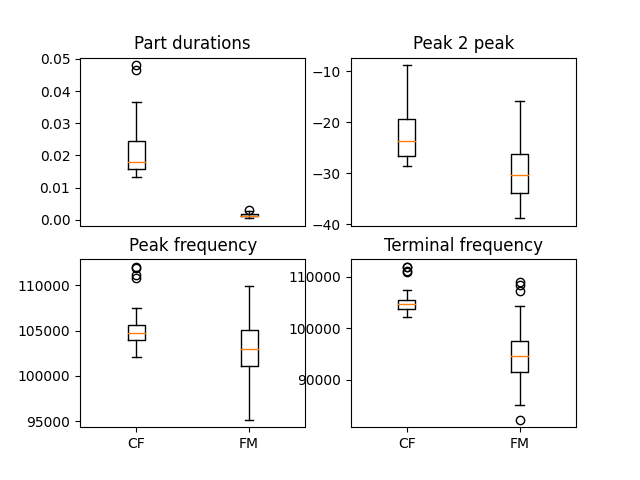

In [9]:
fm_rows = ['fm' in each for each in cleaned['region_id']]
cf_rows = np.invert(fm_rows)

cf_msmts = cleaned[cf_rows]
fm_msmts = cleaned[fm_rows]

plt.figure()
plt.subplot(221)
plt.boxplot([cf_msmts['duration'], fm_msmts['duration']]); plt.xticks([])
plt.title('Part durations');

plt.subplot(222)
plt.boxplot([dB(cf_msmts['peak_amplitude']), dB(fm_msmts['peak_amplitude'])]); plt.xticks([]);
plt.title('Peak 2 peak');

plt.subplot(223)
plt.boxplot([cf_msmts['peak_frequency'], fm_msmts['peak_frequency']]); plt.xticks([1,2],['CF','FM']);
plt.title('Peak frequency');


plt.subplot(224)
plt.boxplot([cf_msmts['terminal_frequency'], fm_msmts['terminal_frequency']]); plt.xticks([1,2],['CF','FM']);
plt.title('Terminal frequency');

### How do the CF and FM durations compare against group size?

<IPython.core.display.Javascript object>


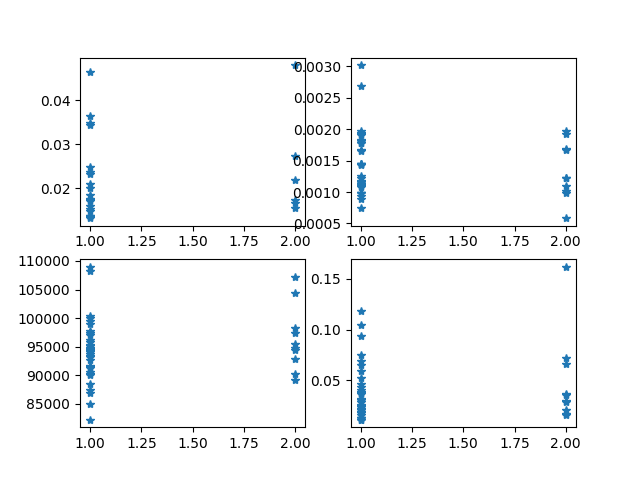

In [10]:
plt.figure()
plt.subplot(221);plt.plot(cf_msmts['num_bats'], cf_msmts['duration'],'*');
plt.subplot(222);plt.plot(fm_msmts['num_bats'], fm_msmts['duration'],'*');
plt.subplot(223);plt.plot(fm_msmts['num_bats'], fm_msmts['terminal_frequency'],'*');
plt.subplot(224);plt.plot(fm_msmts['num_bats'], fm_msmts['peak_amplitude'],'*');

In [11]:
cf_msmts

,Unnamed: 0,audio_file,duration,peak_amplitude,peak_freq_resolution,peak_frequency,region_id,rms,start,stop,terminal_frequency,terminal_frequency_threshold,video_annot_id,num_bats
1,1,segment_matching_annotaudio_Aditya_2018-08-17_...,0.021004,0.049286,95.201828,104837.173872,cf1,0.023391,0.001904,0.022908,104646.733955,-10,Aditya_2018-08-17_12_50,1
3,0,segment_matching_annotaudio_Aditya_2018-08-17_...,0.017484,0.077606,114.364135,105696.636925,cf1,0.036938,0.000864,0.018348,105582.246625,-10,Aditya_2018-08-17_12_74,1
6,1,segment_matching_annotaudio_Aditya_2018-08-17_...,0.034956,0.037445,57.208238,102528.893466,cf1,0.018171,0.001528,0.036484,102471.678682,-10,Aditya_2018-08-17_12_29,1
8,0,segment_matching_annotaudio_Aditya_2018-08-17_...,0.020156,0.043671,99.206349,104633.855924,cf1,0.019810,0.000604,0.020760,104633.855924,-10,Aditya_2018-08-17_12_71,1
10,0,segment_matching_annotaudio_Aditya_2018-08-17_...,0.013264,0.062042,150.693189,104417.973462,cf1,0.032813,0.000936,0.014200,104267.189385,-10,Aditya_2018-08-17_12_8,1
13,1,segment_matching_annotaudio_Aditya_2018-08-17_...,0.021956,0.221893,91.074681,104709.418838,cf1,0.115031,0.001864,0.023820,104572.781927,-10,Aditya_2018-08-17_12_53,2
16,1,segment_matching_annotaudio_Aditya_2018-08-17_...,0.017260,0.037140,115.848007,105040.556199,cf1,0.016545,0.002092,0.019352,104924.681344,-10,Aditya_2018-08-17_12_68,2
18,0,segment_matching_annotaudio_Aditya_2018-08-17_...,0.016756,0.158600,119.331742,107543.566484,cf1,0.074848,0.001224,0.017980,107364.526140,-10,Aditya_2018-08-17_12_77,2
21,1,segment_matching_annotaudio_Aditya_2018-08-17_...,0.048000,0.078033,41.659723,104750.000000,cf1,0.031297,0.001112,0.049112,104583.333333,-10,Aditya_2018-08-17_12_39,2
23,0,segment_matching_annotaudio_Aditya_2018-08-17_...,0.015640,0.046051,127.811861,102301.790281,cf1,0.022138,0.000596,0.016236,102237.851662,-10,Aditya_2018-08-17_12_28,2
